# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Wed May 10 10:32:48 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-10 10:32:49


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [965]:
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number = 3733
#run_number = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
#run_number = 3782
#run_number = 3784
#run_number = 3788
#run_number = 3790
#run_number = 3793
#run_number = 3795
#run_number = 3822
#run_number = 3824
run_number = 3826
#run_number = 3829
#run_number = 3855
#run_number = 3883

#run_number = 3614





In [966]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [967]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/dst_3826.root.h5


In [968]:
full = load_dst(ifile)
print(len(full))
full.head()

3729


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.493666e+09,0,1,275.0,202.234833,1111.640919,631650.0,6.302250,15186.260742,...,652512.5,21,20.8625,20.8625,167.443276,104.378294,197.312136,0.557423,10.209529,8.731225
1,4,1.493666e+09,0,1,300.0,318.950653,1777.395777,162350.0,26.213500,3836.336426,...,656537.5,3,494.1875,494.1875,41.920476,-151.236978,156.939318,-1.300401,4.638244,4.867425
2,6,1.493666e+09,0,1,300.0,268.916504,1470.608483,544625.0,18.843750,16705.142578,...,654487.5,21,109.8625,109.8625,50.560712,13.478097,52.326328,0.260515,9.080869,8.980718
3,11,1.493666e+09,0,1,325.0,531.026794,3274.181231,103900.0,15.073875,3402.157959,...,656987.5,14,553.0875,553.0875,-90.444360,87.914071,126.131146,2.370380,9.004851,9.311412
4,12,1.493666e+09,0,1,300.0,278.104279,1544.998289,376525.0,14.822500,8728.995117,...,655662.5,23,279.1375,279.1375,-59.569889,-64.797157,88.018425,-2.314188,10.481693,9.744044


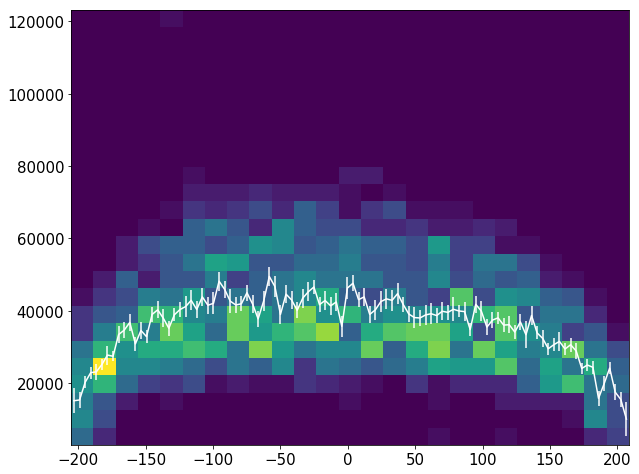

In [969]:
plt.figure(figsize=(10,8))
c = full
c = full[full.Y > -100]
c = c[c.Y <  100]
#c = c[c.Z > 100]
#plt.scatter(c.X, c.S2e)
a = fitf.profileX(c.X, c.S2e, 100)
plt.hist2d(c.X, c.S2e, bins=25)
#plt.ylim((50000,150000))
plt.errorbar(*a, c='white')
plt.show()


In [970]:
msc = full[full.S2e  >  400*units.pes * 11] # michel sorel cuts
msc = msc [msc.S1e   >   100*units.pes * 11] 
msc = msc [msc.S2w   > 3.5] # units of mus!!!
msc = msc [msc.S2w   <  25] # units of mus!!! 
msc = msc [msc.S1w   >  300*units.ns]
msc = msc [msc.S1w   < 1000*units.ns] 
msc = msc [msc.S1t   >  100*units.mus]
msc = msc [msc.S2t   <  700*units.mus]

msc = msc [msc.R     <  100*units.mm] # fidc

large_drift = full[full.DT > 530]


In [971]:
len(full)

3729

In [972]:
r = event_rate(full)

In [973]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 1.0045156060918243 evts/s


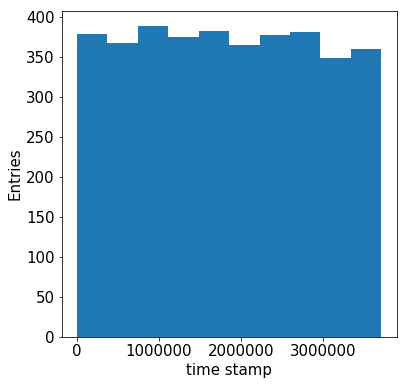

In [974]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

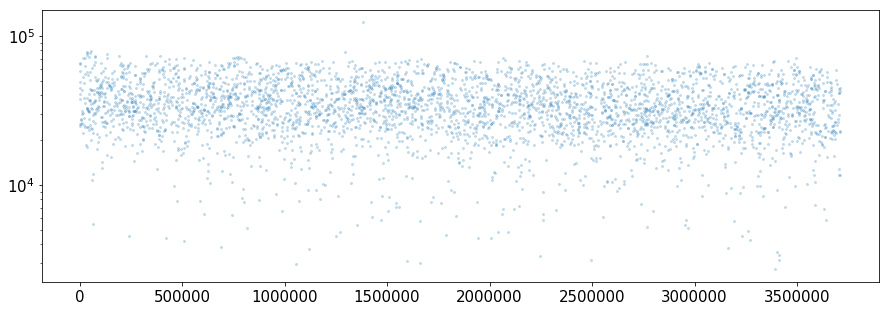

In [975]:
plt.figure(figsize=(15,5))
plt.scatter(1e+3*(full.time - full.time[0]), full.S2e, alpha=.2, s=4)
plt.yscale('log')
plt.show()

In [976]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

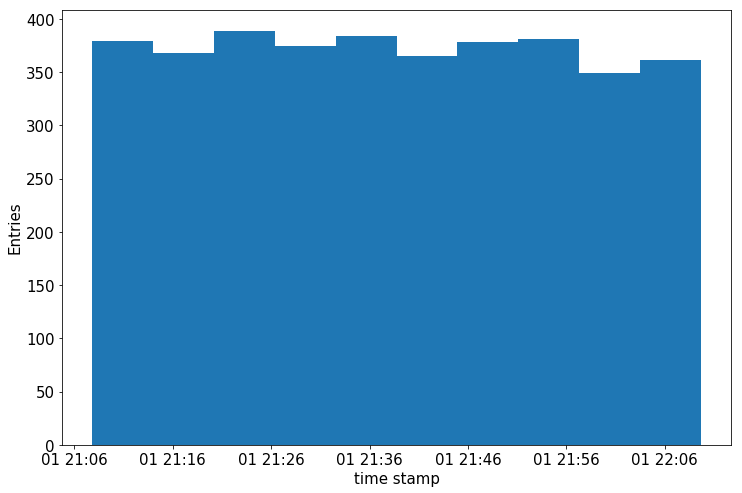

In [977]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [978]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [979]:
print(st)

2017-05-01 22:09:40


In [980]:
print(full.time.index[-1])

3728


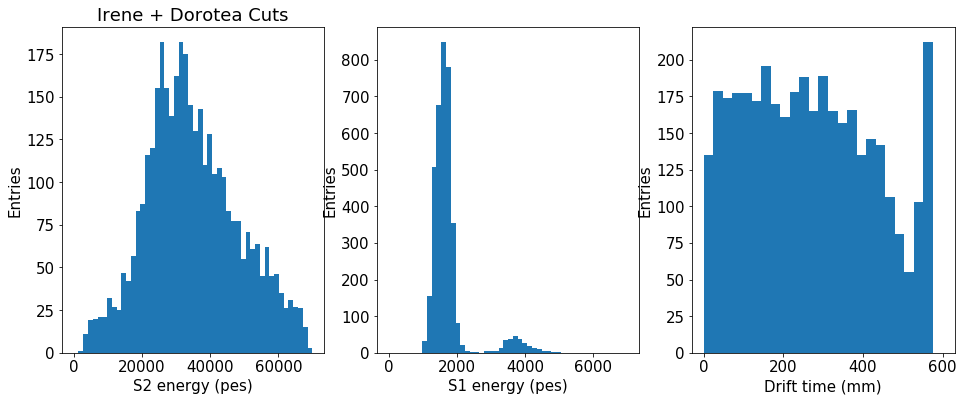

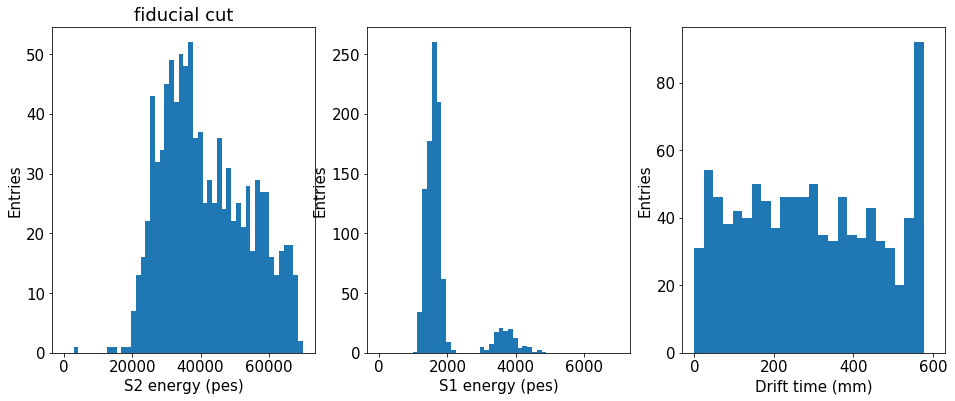

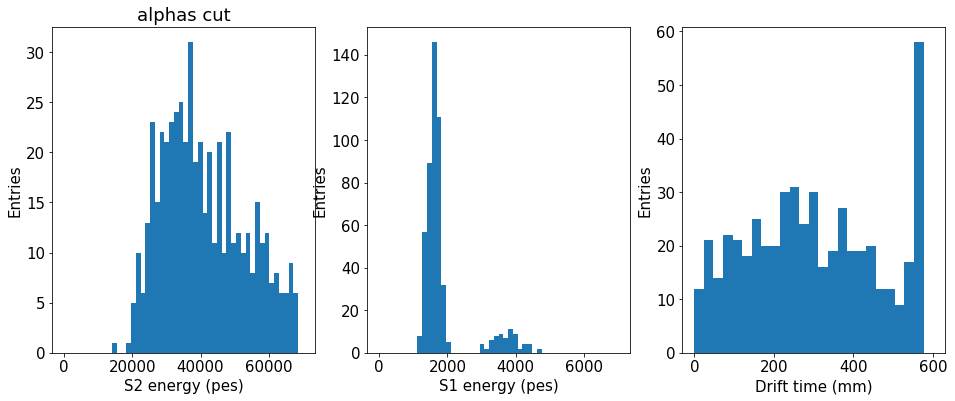

In [981]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fidc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fiducial cut')

ax = plt.subplot(1, 3, 2)
plt.hist(fidc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(fidc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(msc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('alphas cut')

ax = plt.subplot(1, 3, 2)
plt.hist(msc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(msc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

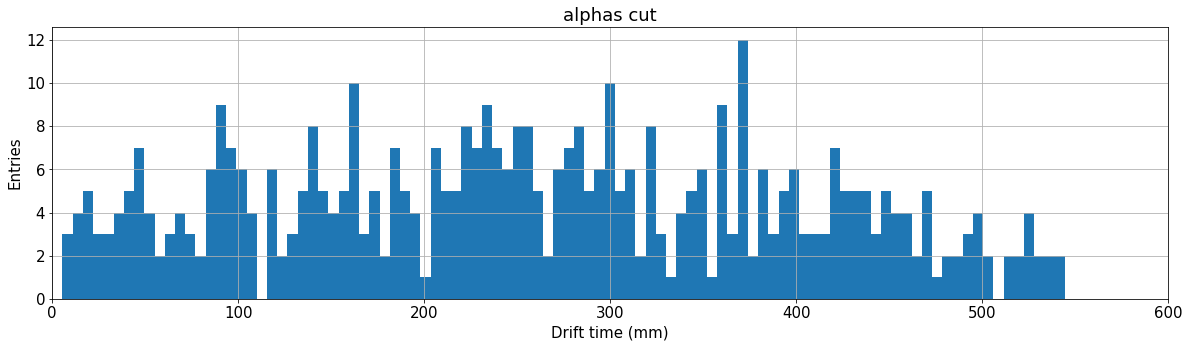

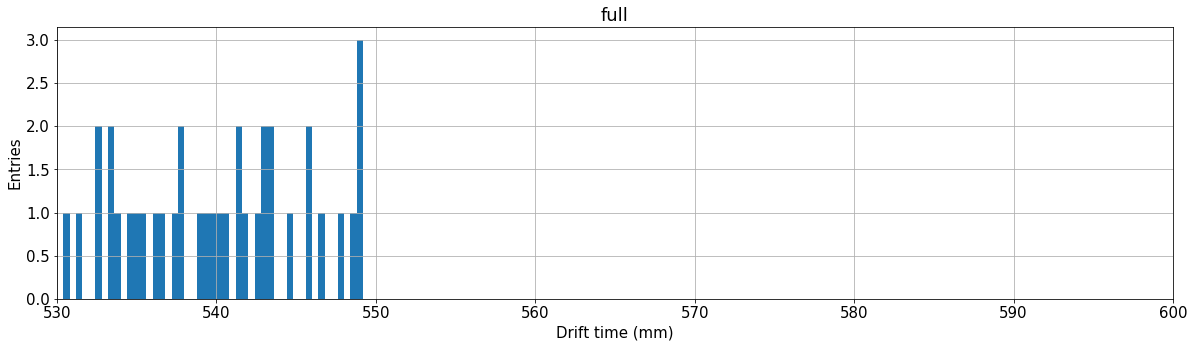

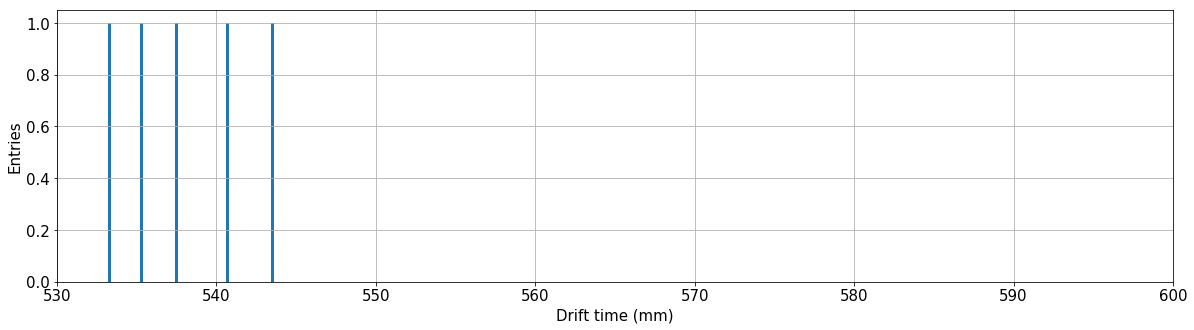

In [982]:
plt.figure(figsize=(20,5))
b = plt.hist(msc.Z, 100, (0, 550))
plt.xlim(0,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('alphas cut')




plt.figure(figsize=(20,5))
a = plt.hist(full[full.Z > 530].Z, 50, (530, 550))
plt.xlim(530,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('full')


    

plt.figure(figsize=(20,5))
b = plt.hist(msc[msc.Z > 530].Z, 100, (530, 550))
plt.xlim(530,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
#plt.title('alphas cut')



### Dependence with Z all alphas

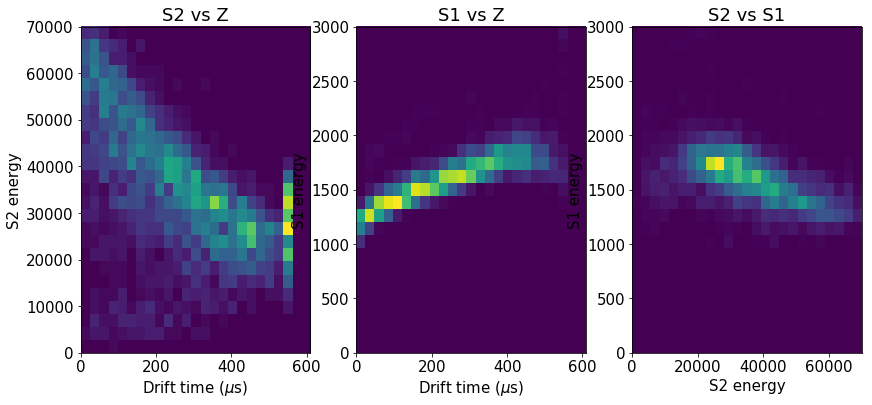

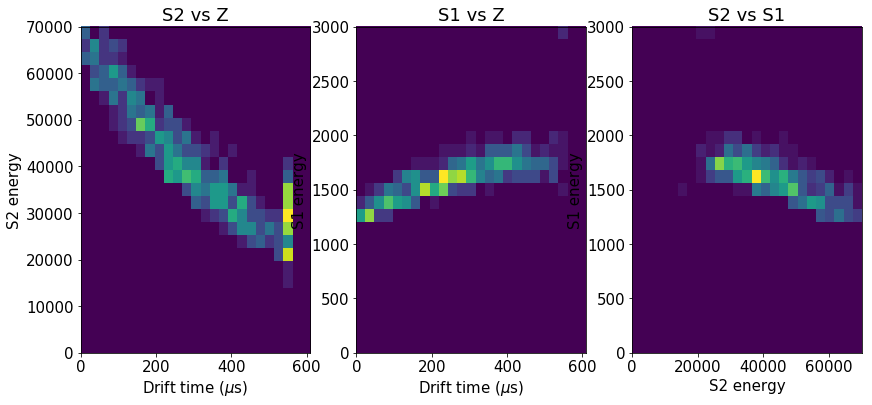

In [983]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(msc.Z, msc.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(msc.Z, msc.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(msc.S2e, msc.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [984]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))

core2 = full[full.Z > 300]
core2 = core2[core2.Z < 500]

#core= msc

Ratio wrt full: 0.2716545990882274


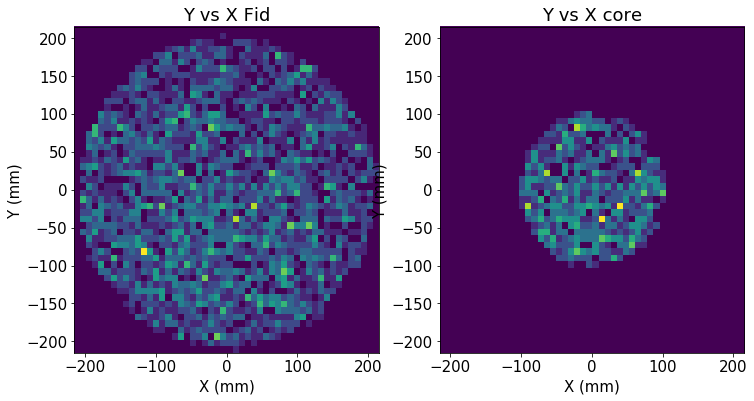

In [985]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 68976.46396042737 error = 495.46866700619825
fit par[1] = -516.2185177246876 error = 8.89414496514245
degrees of freedom = 2
chi2 = 0.8738950056976603


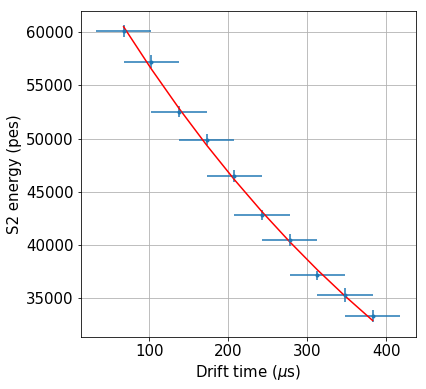

In [986]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [987]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.16599624564226334


#### Fit S2 in fiducial 

fit par[0] = 68976.46396042737 error = 495.46866700619825
fit par[1] = -516.2185177246876 error = 8.89414496514245
degrees of freedom = 2
chi2 = 0.8738950056976603


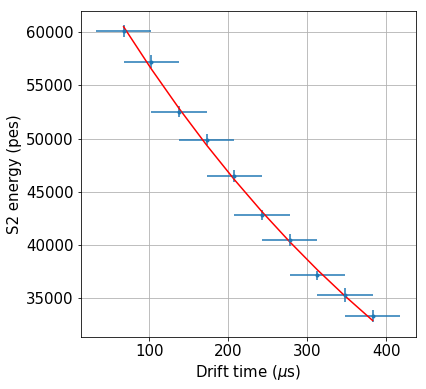

In [988]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [989]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-05-01 21:07:48 t1 = 2017-05-01 22:09:40


In [990]:
len(cz)

619

using data set with length 619
t0 = 2017-05-01 21:07:49 (index = 0) t1 = 2017-05-01 22:09:33 (index = 619)
bin length = 123
 ---fit over events between 0 and 122
time0 = 2017-05-01 21:07:49 time1 = 2017-05-01 21:22:16
size of time leg = 122
fit par[0] = 75071.59696058239 error = 1515.8971882988565
fit par[1] = -514.3922260815741 error = 22.69602583695002
degrees of freedom = 2
chi2 = 1.090298332201635
 ---fit over events between 123 and 245
time0 = 2017-05-01 21:22:23 time1 = 2017-05-01 21:33:35
size of time leg = 122
fit par[0] = 72031.25792915635 error = 1344.0971733061501
fit par[1] = -494.4138086197269 error = 21.051236546305105
degrees of freedom = 2
chi2 = 1.6935928545505157
 ---fit over events between 246 and 368
time0 = 2017-05-01 21:33:37 time1 = 2017-05-01 21:45:36
size of time leg = 122
fit par[0] = 69264.30144436794 error = 1889.8025869245164
fit par[1] = -506.6938526486531 error = 36.39618990000511
degrees of freedom = 2
chi2 = 1.568249110652107
 ---fit over events between

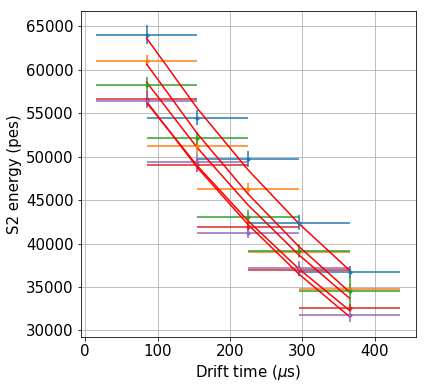

In [991]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [992]:
plot_options()

In [993]:
TSTAMP

['2017-05-01 21:22:16',
 '2017-05-01 21:33:35',
 '2017-05-01 21:45:36',
 '2017-05-01 21:57:41',
 '2017-05-01 22:08:49']

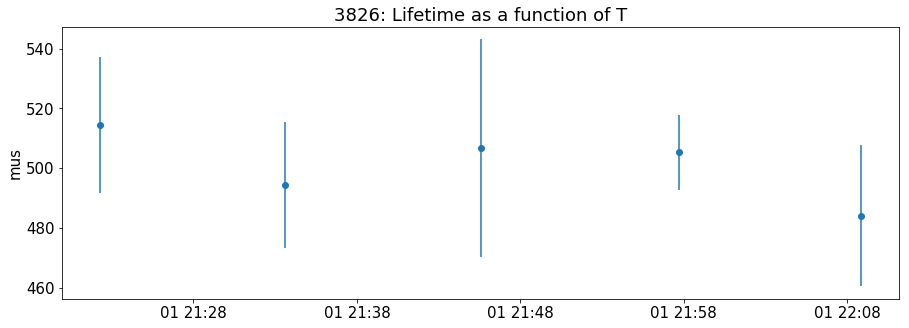

In [994]:
figsize=(15,5)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()



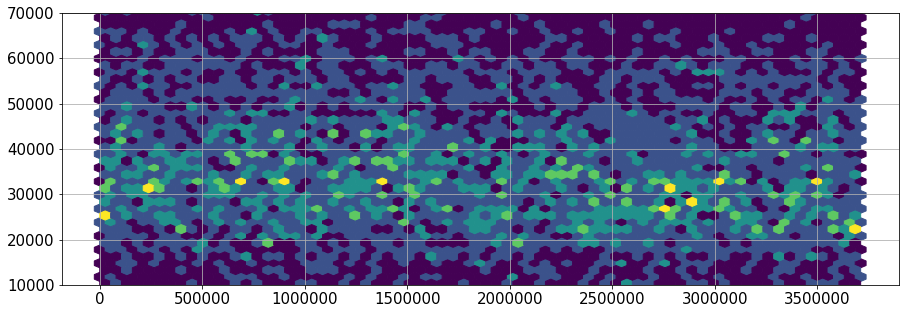

In [995]:
plt.figure(figsize=figsize)
plt.hexbin(1e+3*(full.time - full.time[0]), full.S2e, bins=5, gridsize=70)
#plt.yscale('log')
plt.ylim(10000,70000)
#plt.ylabel('S2e')
plt.grid(True)
plt.show()

In [996]:
print(-np.array(LAMBDA)[-2], np.array(ELAMBDA)[-2])


505.332790992 12.5230282232


In [997]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')

pfiles = [
          plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt',
          plog + 'GAS_Log_2017-04-21.txt',
          plog + 'GAS_Log_2017-04-22.txt',
          plog + 'GAS_Log_2017-04-23.txt',
          plog + 'GAS_Log_2017-04-24.txt',
          plog + 'GAS_Log_2017-04-25.txt',
          plog + 'GAS_Log_2017-04-26.txt',
          plog + 'GAS_Log_2017-04-27.txt',
          plog + 'GAS_Log_2017-04-28.txt',
          plog + 'GAS_Log_2017-04-29.txt',
          plog + 'GAS_Log_2017-04-30.txt',
          plog + 'GAS_Log_2017-05-01.txt',
          plog + 'GAS_Log_2017-05-02.txt'
        ]

print(pfiles)

['/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-15.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-16.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-17.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-18.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-19.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-20.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-21.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-22.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-23.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-24.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-25.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-26.txt', '/Users/alej/Desktop/IC_DAT

In [998]:
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python', decimal=",")
f0

,Date,Hour,VG1,VG2,VG3,VG4,PG1,PG2,PG3,PG4,PG5,PG6,PGR2.2
0,15/04/2017,0:00:19,"2,035638E-5","3,298279E-6","1,492910E-6","1,937365E+0","-1,335449E-1","9,675583E+0","6,942719E+0","9,101624E+0","6,696808E+0","6,138596E+0","7,672455E+0"
1,15/04/2017,0:00:50,"2,035871E-5","3,298279E-6","1,492910E-6","1,937365E+0","-1,340790E-1","9,639053E+0","6,937912E+0","9,081482E+0","6,706039E+0","6,171326E+0","7,675812E+0"
2,15/04/2017,0:01:20,"2,037548E-5","3,299210E-6","1,492910E-6","1,937365E+0","-1,308746E-1","9,581650E+0","6,950729E+0","9,091553E+0","6,659882E+0","6,236786E+0","7,672455E+0"
3,15/04/2017,0:01:51,"2,037035E-5","3,299210E-6","1,492910E-6","1,937365E+0","-1,356812E-1","9,670364E+0","6,939514E+0","9,059662E+0","6,692612E+0","6,274551E+0","7,668259E+0"
4,15/04/2017,0:02:22,"2,037035E-5","3,299676E-6","1,492910E-6","1,937138E+0","-1,367493E-1","9,628616E+0","6,936844E+0","9,054626E+0","6,687576E+0","6,194824E+0","7,669098E+0"
5,15/04/2017,0:02:52,"2,051191E-5","3,314111E-6","1,499429E-6","1,937365E+0","-1,394196E-1","9,748642E+0","6,948593E+0","9,055466E+0","6,707718E+0","6,141113E+0","7,674133E+0"
6,15/04/2017,0:03:22,"2,048537E-5","3,311317E-6","1,498498E-6","1,937592E+0","-1,319427E-1","9,487717E+0","6,949661E+0","9,062180E+0","6,677505E+0","6,157898E+0","7,669098E+0"
7,15/04/2017,0:03:53,"2,046162E-5","3,308989E-6","1,498032E-6","1,937365E+0","-1,346130E-1","9,769516E+0","6,942719E+0","9,048752E+0","6,676666E+0","6,215805E+0","7,669098E+0"
8,15/04/2017,0:04:23,"2,043974E-5","3,307126E-6","1,496635E-6","1,937365E+0","-1,324768E-1","9,560776E+0","6,955002E+0","9,063019E+0","6,668274E+0","6,281265E+0","7,673294E+0"
9,15/04/2017,0:04:54,"2,049981E-5","3,311783E-6","1,498498E-6","1,937365E+0","-1,372833E-1","9,837357E+0","6,948059E+0","9,064697E+0","6,680023E+0","6,354279E+0","7,669098E+0"


In [999]:
#f = pd.read_csv(ppath, skiprows=2, sep=None, engine='python')

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
    print(len(T),len(pg3))


2843 2843
5688 5688
8532 8532
11637 11637
14483 14483
17325 17325
20170 20170
23016 23016
25860 25860
28544 28544
31380 31380
34233 34233
37086 37086
39944 39944
42804 42804
45665 45665
48521 48521
51376 51376


In [749]:
days = 30
tlog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/temperature/Data/')
tfiles = [tlog + 'PWR_Data_Report_2017-04-15.txt',
          tlog + 'PWR_Data_Report_2017-04-16.txt',
          tlog + 'PWR_Data_Report_2017-04-17.txt',
          tlog + 'PWR_Data_Report_2017-04-18.txt',
          tlog + 'PWR_Data_Report_2017-04-19.txt',
          tlog + 'PWR_Data_Report_2017-04-20.txt',
          tlog + 'PWR_Data_Report_2017-04-21.txt',
          tlog + 'PWR_Data_Report_2017-04-22.txt',
          tlog + 'PWR_Data_Report_2017-04-23.txt',
          tlog + 'PWR_Data_Report_2017-04-24.txt',
          tlog + 'PWR_Data_Report_2017-04-25.txt',
          tlog + 'PWR_Data_Report_2017-04-26.txt',
          tlog + 'PWR_Data_Report_2017-04-27.txt',
          tlog + 'PWR_Data_Report_2017-04-28.txt',
          tlog + 'PWR_Data_Report_2017-04-29.txt',
          tlog + 'PWR_Data_Report_2017-04-30.txt',
          tlog + 'PWR_Data_Report_2017-05-01.txt',
          tlog + 'PWR_Data_Report_2017-05-02.txt']

In [750]:
f0 = pd.read_csv(tfiles[0], skiprows=2, sep='\s+', engine='python')
f0

,Date,Hour,DB1_Vout(V),DB1_Temp(�C),DB1_Curr(uA),DB2_Vout(V),DB2_Temp(�C),DB2_Curr(uA),DB3_Vout(V),DB3_Temp(�C),...,DB25_Curr(uA),DB26_Vout(V),DB26_Temp(�C),DB26_Curr(uA),DB27_Vout(V),DB27_Temp(�C),DB27_Curr(uA),DB28_Vout(V),DB28_Temp(�C),DB28_Curr(uA)
0,15/04/2017,0:01:29,27.56,20.87,1.31,27.56,21.07,1.50,27.56,21.05,...,1.03,27.56,20.87,1.09,27.56,20.96,1.58,27.56,21.12,1.40
1,15/04/2017,0:11:29,27.56,20.87,0.99,27.56,21.07,1.52,27.56,21.05,...,1.25,27.56,20.87,1.43,27.56,20.96,1.63,27.56,21.12,1.32
2,15/04/2017,0:21:31,27.56,20.87,1.81,27.56,21.07,1.71,27.56,21.05,...,1.27,27.56,20.87,1.42,27.56,20.97,1.84,27.56,21.12,1.16
3,15/04/2017,0:31:33,27.56,20.87,1.75,27.56,21.07,1.34,27.56,21.06,...,0.87,27.56,20.87,1.10,27.56,20.97,1.23,27.57,21.12,1.63
4,15/04/2017,0:41:34,27.56,20.87,1.16,27.57,21.07,1.56,27.56,21.06,...,1.11,27.56,20.87,1.32,27.56,20.97,0.98,27.56,21.12,1.53
5,15/04/2017,0:51:34,27.56,20.87,1.51,27.56,21.07,1.39,27.56,21.06,...,1.10,27.56,20.87,0.99,27.56,20.97,1.51,27.56,21.12,1.77
6,15/04/2017,1:01:34,27.56,20.87,1.41,27.56,21.07,1.53,27.56,21.06,...,1.07,27.56,20.87,1.60,27.56,20.97,1.86,27.56,21.12,1.73
7,15/04/2017,1:11:34,27.56,20.87,1.46,27.57,21.07,1.12,27.56,21.06,...,1.18,27.56,20.87,1.31,27.56,20.97,1.32,27.56,21.12,1.06
8,15/04/2017,1:21:34,27.56,20.87,1.12,27.57,21.07,1.72,27.56,21.06,...,1.17,27.56,20.87,0.97,27.56,20.97,1.69,27.56,21.12,1.32
9,15/04/2017,1:31:34,27.56,20.87,1.22,27.57,21.08,0.85,27.56,21.06,...,1.32,27.56,20.87,1.55,27.56,20.97,1.63,27.56,21.13,0.71


In [751]:
tfiles

['/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-15.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-16.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-17.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-18.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-19.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-20.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-21.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-22.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-23.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-24.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-25.txt',
 '/Users/alej/Desktop

In [752]:
Tt=[]
dbs=[]
for f in tfiles: 
    f = pd.read_csv(f, skiprows=2, sep='\s+', engine='python')

    for i, (d, t) in enumerate(zip(f['Date'].values, f['Hour'].values)):
        if len(t)==7: t = '0' + t
        Tt.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        dbs.append([f['DB1_Temp(�C)'][i],  f['DB2_Temp(�C)'] [i], f['DB3_Temp(�C)'] [i],
                    f['DB4_Temp(�C)'][i],  f['DB5_Temp(�C)'] [i], f['DB6_Temp(�C)'] [i],
                    f['DB7_Temp(�C)'][i],  f['DB8_Temp(�C)'] [i], f['DB9_Temp(�C)'] [i],
                    f['DB10_Temp(�C)'][i], f['DB11_Temp(�C)'][i], f['DB12_Temp(�C)'][i],
                    f['DB13_Temp(�C)'][i], f['DB14_Temp(�C)'][i], f['DB15_Temp(�C)'][i],
                    f['DB16_Temp(�C)'][i], f['DB17_Temp(�C)'][i], f['DB18_Temp(�C)'][i],
                    f['DB19_Temp(�C)'][i], f['DB20_Temp(�C)'][i], f['DB21_Temp(�C)'][i],
                    f['DB22_Temp(�C)'][i], f['DB23_Temp(�C)'][i], f['DB24_Temp(�C)'][i],
                    f['DB25_Temp(�C)'][i], f['DB26_Temp(�C)'][i], f['DB27_Temp(�C)'][i],
                    f['DB28_Temp(�C)'][i]])

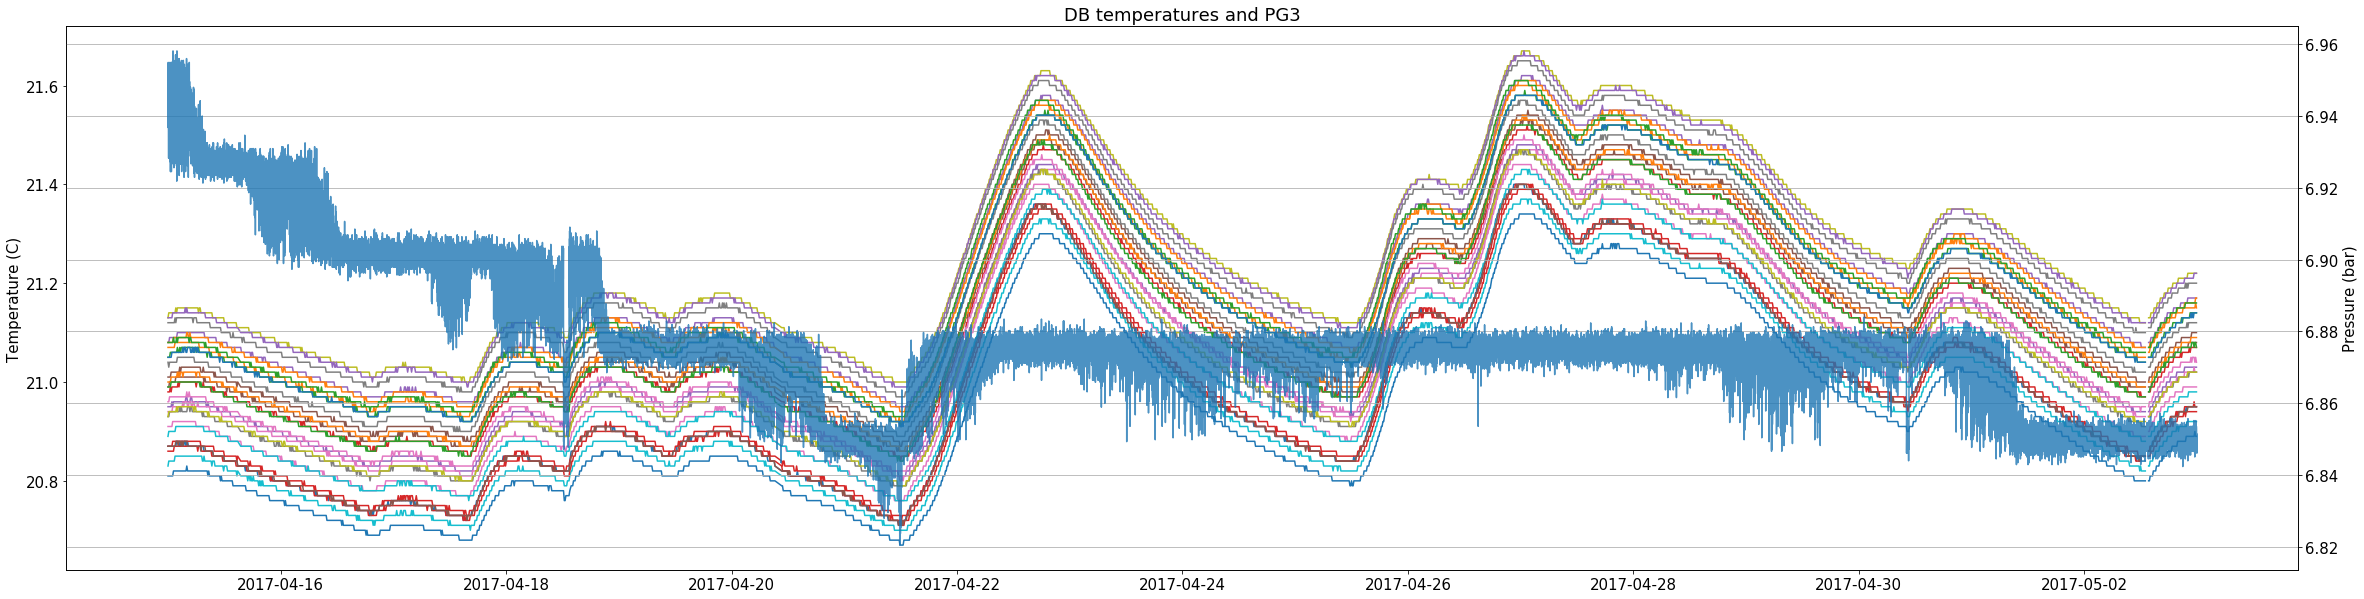

In [753]:
fig, ax1 = plt.subplots(figsize=(40, 10))

#plt.legend(loc=2)
ax1.plot(Tt, dbs)
ax1.set_ylabel('Temperature (C)')
ax2=ax1.twinx()
ax2.plot(T, [float(v.replace(',','.')) for v in pg3],alpha=.8)
ax2.set_ylabel('Pressure (bar)')
plt.title('DB temperatures and PG3')
plt.grid(True)
plt.show()

In [754]:
np.array([float(v.replace(',','.')) for v in pg3])

array([ 6.942719,  6.937912,  6.950729, ...,  6.851395,  6.84819 ,
        6.848724])